<a href="https://colab.research.google.com/github/blackbtccollins/AIML_Training/blob/main/class/Blackburn_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [185]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [186]:
epochs = 50                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 200          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [187]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [188]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Best####

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10000))  
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


In [189]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###BEST - Save ####

#model = Sequential()
#
#model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
#model.add(Dropout(0.3))
#model.add(Activation('relu'))
#model.add(Conv2D(64, kernel_size=(3,3)))
#model.add(LeakyReLU(alpha=0.05))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(100))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(Dense(num_classes, activation="softmax"))
#
#my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

## Fit and Evaluate the Model

In [190]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



not using image augmentation
Epoch 1/50
201/201 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7968

201/201 [==============================] - 14s 69ms/step - loss: 0.6563 - accuracy: 0.7968 - val_loss: 0.3873 - val_accuracy: 0.8710
Epoch 2/50
201/201 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8845

201/201 [==============================] - 15s 74ms/step - loss: 0.3153 - accuracy: 0.8845 - val_loss: 0.3266 - val_accuracy: 0.8845
Epoch 3/50
201/201 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9025

201/201 [==============================] - 13s 67ms/step - loss: 0.2583 - accuracy: 0.9025 - val_loss: 0.2817 - val_accuracy: 0.9028
Epoch 4/50
201/201 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9203

201/201 [==============================] - 13s 66ms/step - loss: 0.2151 - accuracy: 0.9203 - val_loss: 0.2801 - val_accuracy: 0.8980
Epoch 5/50
201/201 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.9293

201/201 [==============================] - 13s 66ms/step - loss: 0.1880 - accuracy: 0.9293 - val_loss: 0.2433 - val_accuracy: 0.9122
Epoch 6/50
201/201 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9420

201/201 [==============================] - 13s 66ms/step - loss: 0.1547 - accuracy: 0.9420 - val_loss: 0.2464 - val_accuracy: 0.9115
Epoch 7/50
201/201 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9493

201/201 [==============================] - 13s 66ms/step - loss: 0.1344 - accuracy: 0.9493 - val_loss: 0.2382 - val_accuracy: 0.9179
Epoch 8/50
201/201 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9587

201/201 [==============================] - 14s 72ms/step - loss: 0.1085 - accuracy: 0.9587 - val_loss: 0.2495 - val_accuracy: 0.9146
Epoch 9/50
201/201 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9645

201/201 [==============================] - 14s 71ms/step - loss: 0.0939 - accuracy: 0.9645 - val_loss: 0.2587 - val_accuracy: 0.9171
Epoch 10/50
201/201 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9722

201/201 [==============================] - 14s 71ms/step - loss: 0.0765 - accuracy: 0.9722 - val_loss: 0.2654 - val_accuracy: 0.9170
Epoch 11/50
201/201 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9769

201/201 [==============================] - 14s 71ms/step - loss: 0.0634 - accuracy: 0.9769 - val_loss: 0.2752 - val_accuracy: 0.9175
Epoch 12/50
201/201 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9799

201/201 [==============================] - 13s 66ms/step - loss: 0.0535 - accuracy: 0.9799 - val_loss: 0.2943 - val_accuracy: 0.9188
Epoch 13/50
201/201 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9838

201/201 [==============================] - 14s 71ms/step - loss: 0.0466 - accuracy: 0.9838 - val_loss: 0.2908 - val_accuracy: 0.9216
Epoch 14/50
201/201 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9857

201/201 [==============================] - 14s 71ms/step - loss: 0.0401 - accuracy: 0.9857 - val_loss: 0.2968 - val_accuracy: 0.9208
Epoch 15/50
201/201 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9889

201/201 [==============================] - 13s 66ms/step - loss: 0.0328 - accuracy: 0.9889 - val_loss: 0.3194 - val_accuracy: 0.9219
Epoch 16/50
201/201 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9891

201/201 [==============================] - 14s 71ms/step - loss: 0.0298 - accuracy: 0.9891 - val_loss: 0.3361 - val_accuracy: 0.9184
Epoch 17/50
201/201 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9920

201/201 [==============================] - 13s 66ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.3537 - val_accuracy: 0.9211
Epoch 18/50
201/201 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9906

201/201 [==============================] - 14s 71ms/step - loss: 0.0272 - accuracy: 0.9906 - val_loss: 0.3300 - val_accuracy: 0.9208
Epoch 19/50
201/201 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9915

201/201 [==============================] - 14s 72ms/step - loss: 0.0240 - accuracy: 0.9915 - val_loss: 0.3445 - val_accuracy: 0.9181
Epoch 20/50
201/201 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9937

201/201 [==============================] - 13s 66ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.3661 - val_accuracy: 0.9219
Epoch 21/50
201/201 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9943

201/201 [==============================] - 14s 71ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.3961 - val_accuracy: 0.9173
Epoch 22/50
201/201 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9935

201/201 [==============================] - 14s 71ms/step - loss: 0.0178 - accuracy: 0.9935 - val_loss: 0.3908 - val_accuracy: 0.9188
Epoch 23/50
201/201 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9947

201/201 [==============================] - 13s 66ms/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.4243 - val_accuracy: 0.9191
Epoch 24/50
201/201 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9929

201/201 [==============================] - 14s 71ms/step - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.3869 - val_accuracy: 0.9165
Epoch 25/50
201/201 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9941

201/201 [==============================] - 13s 66ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.3979 - val_accuracy: 0.9185
Epoch 26/50
201/201 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9958

201/201 [==============================] - 13s 66ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.3783 - val_accuracy: 0.9230
Epoch 27/50
201/201 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9967

201/201 [==============================] - 14s 71ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.4071 - val_accuracy: 0.9190
Epoch 28/50
201/201 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9960

201/201 [==============================] - 13s 66ms/step - loss: 0.0115 - accuracy: 0.9960 - val_loss: 0.4224 - val_accuracy: 0.9185
Epoch 29/50
201/201 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9950

201/201 [==============================] - 14s 71ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.4493 - val_accuracy: 0.9134
Epoch 30/50
201/201 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9952

201/201 [==============================] - 14s 71ms/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.4274 - val_accuracy: 0.9216
Epoch 31/50
201/201 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9970

201/201 [==============================] - 14s 71ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.4136 - val_accuracy: 0.9220
Epoch 32/50
201/201 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9957

201/201 [==============================] - 13s 66ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.4142 - val_accuracy: 0.9214
Epoch 33/50
201/201 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9963

201/201 [==============================] - 14s 71ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.4518 - val_accuracy: 0.9182
Epoch 34/50
201/201 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9957

201/201 [==============================] - 13s 66ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.4358 - val_accuracy: 0.9207
Epoch 35/50
201/201 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9973

201/201 [==============================] - 13s 66ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.4213 - val_accuracy: 0.9239
Epoch 36/50
201/201 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9975

201/201 [==============================] - 13s 67ms/step - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.4347 - val_accuracy: 0.9223
Epoch 37/50
201/201 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9970

201/201 [==============================] - 14s 71ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.4612 - val_accuracy: 0.9239
Epoch 38/50
201/201 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9957

201/201 [==============================] - 13s 65ms/step - loss: 0.0112 - accuracy: 0.9957 - val_loss: 0.4847 - val_accuracy: 0.9174
Epoch 39/50
201/201 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9966

201/201 [==============================] - 13s 65ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.4479 - val_accuracy: 0.9177
Epoch 40/50
201/201 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9967

201/201 [==============================] - 14s 71ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.4711 - val_accuracy: 0.9220
Epoch 41/50
201/201 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9964

201/201 [==============================] - 13s 66ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.4514 - val_accuracy: 0.9207
Epoch 42/50
201/201 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9968

201/201 [==============================] - 14s 71ms/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.4763 - val_accuracy: 0.9179
Epoch 43/50
201/201 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9975

201/201 [==============================] - 13s 65ms/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 0.4966 - val_accuracy: 0.9183
Epoch 44/50
201/201 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9966

201/201 [==============================] - 13s 65ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 0.4673 - val_accuracy: 0.9213
Epoch 45/50
201/201 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9972

201/201 [==============================] - 13s 65ms/step - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.4836 - val_accuracy: 0.9196
Epoch 46/50
201/201 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983

201/201 [==============================] - 14s 71ms/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.5325 - val_accuracy: 0.9241
Epoch 47/50
201/201 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9974

201/201 [==============================] - 13s 65ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.5498 - val_accuracy: 0.9165
Epoch 48/50
201/201 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979

201/201 [==============================] - 13s 66ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.4884 - val_accuracy: 0.9229
Epoch 49/50
201/201 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9979

201/201 [==============================] - 14s 71ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.5161 - val_accuracy: 0.9202
Epoch 50/50
201/201 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985

619/619 [==============================] - 3s 5ms/step - loss: 0.5400 - accuracy: 0.9207

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2051
           1       0.99      0.99      0.99      1956
           2       0.87      0.89      0.88      2013
           3       0.92      0.92      0.92      2008
           4       0.92      0.84      0.88      2031
           5       0.99      0.98      0.99      1923
           6       0.76      0.81      0.78      1952
           7       0.94      0.99      0.96      1920
           8       0.99      0.97      0.98      1911
           9       0.98      0.95      0.97      2035

    accuracy                           0.92     19800
   macro avg       0.92      0.92      0.92     19800
weighted avg       0.92      0.92      0.92     19800

Testing Loss: 0.540002703666687
Testing Accuracy: 0.9207070469856262
END SUBMISSION BLOCK

Model: "sequential_46

## Plot the accuracy vs. validation accuracy

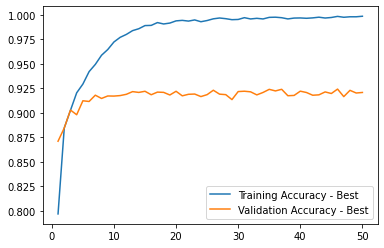

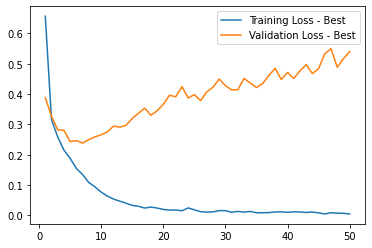

In [191]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss - Best", "Validation Loss - Best"))
plt.show()

## Extra Test Section

In [192]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(400))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

In [193]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = False

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model_1.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist1 = model_1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist1 = model_1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score_1 = model_1.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model_1.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score_1[0])
print("Testing Accuracy:", score_1[1])
print("END SUBMISSION BLOCK\n")

model_1.summary()

not using image augmentation
Epoch 1/50
201/201 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7396

201/201 [==============================] - 4s 20ms/step - loss: 0.7225 - accuracy: 0.7396 - val_loss: 0.5972 - val_accuracy: 0.8356
Epoch 2/50
199/201 [============================>.] - ETA: 0s - loss: 0.4490 - accuracy: 0.8392

201/201 [==============================] - 4s 19ms/step - loss: 0.4481 - accuracy: 0.8395 - val_loss: 0.4512 - val_accuracy: 0.8646
Epoch 3/50
198/201 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.8569

201/201 [==============================] - 4s 19ms/step - loss: 0.3938 - accuracy: 0.8568 - val_loss: 0.3903 - val_accuracy: 0.8776
Epoch 4/50
199/201 [============================>.] - ETA: 0s - loss: 0.3583 - accuracy: 0.8690

201/201 [==============================] - 4s 18ms/step - loss: 0.3579 - accuracy: 0.8690 - val_loss: 0.3698 - val_accuracy: 0.8870
Epoch 5/50
199/201 [============================>.] - ETA: 0s - loss: 0.3365 - accuracy: 0.8759

201/201 [==============================] - 4s 19ms/step - loss: 0.3364 - accuracy: 0.8758 - val_loss: 0.3539 - val_accuracy: 0.8859
Epoch 6/50
200/201 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.8809

201/201 [==============================] - 4s 18ms/step - loss: 0.3209 - accuracy: 0.8810 - val_loss: 0.3184 - val_accuracy: 0.8927
Epoch 7/50
200/201 [============================>.] - ETA: 0s - loss: 0.3047 - accuracy: 0.8877

201/201 [==============================] - 4s 18ms/step - loss: 0.3052 - accuracy: 0.8875 - val_loss: 0.3003 - val_accuracy: 0.9000
Epoch 8/50
198/201 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.8915

201/201 [==============================] - 4s 18ms/step - loss: 0.2930 - accuracy: 0.8914 - val_loss: 0.3025 - val_accuracy: 0.8994
Epoch 9/50
200/201 [============================>.] - ETA: 0s - loss: 0.2835 - accuracy: 0.8948

201/201 [==============================] - 4s 18ms/step - loss: 0.2833 - accuracy: 0.8949 - val_loss: 0.2993 - val_accuracy: 0.9023
Epoch 10/50
200/201 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.8975

201/201 [==============================] - 4s 19ms/step - loss: 0.2737 - accuracy: 0.8975 - val_loss: 0.2822 - val_accuracy: 0.9074
Epoch 11/50
200/201 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.9009

201/201 [==============================] - 4s 18ms/step - loss: 0.2658 - accuracy: 0.9008 - val_loss: 0.2804 - val_accuracy: 0.9087
Epoch 12/50
198/201 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.9052

201/201 [==============================] - 4s 19ms/step - loss: 0.2546 - accuracy: 0.9052 - val_loss: 0.2682 - val_accuracy: 0.9101
Epoch 13/50
201/201 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9066

201/201 [==============================] - 4s 19ms/step - loss: 0.2469 - accuracy: 0.9066 - val_loss: 0.2646 - val_accuracy: 0.9118
Epoch 14/50
200/201 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9111

201/201 [==============================] - 4s 19ms/step - loss: 0.2378 - accuracy: 0.9108 - val_loss: 0.2628 - val_accuracy: 0.9118
Epoch 15/50
198/201 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9139

201/201 [==============================] - 4s 18ms/step - loss: 0.2320 - accuracy: 0.9137 - val_loss: 0.2517 - val_accuracy: 0.9117
Epoch 16/50
201/201 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9149

201/201 [==============================] - 4s 19ms/step - loss: 0.2266 - accuracy: 0.9149 - val_loss: 0.2512 - val_accuracy: 0.9140
Epoch 17/50
199/201 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9170

201/201 [==============================] - 4s 18ms/step - loss: 0.2218 - accuracy: 0.9170 - val_loss: 0.2423 - val_accuracy: 0.9148
Epoch 18/50
199/201 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9177

201/201 [==============================] - 4s 18ms/step - loss: 0.2159 - accuracy: 0.9178 - val_loss: 0.2445 - val_accuracy: 0.9159
Epoch 19/50
199/201 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9216

201/201 [==============================] - 4s 19ms/step - loss: 0.2071 - accuracy: 0.9217 - val_loss: 0.2385 - val_accuracy: 0.9152
Epoch 20/50
200/201 [============================>.] - ETA: 0s - loss: 0.2027 - accuracy: 0.9219

201/201 [==============================] - 4s 19ms/step - loss: 0.2027 - accuracy: 0.9220 - val_loss: 0.2365 - val_accuracy: 0.9184
Epoch 21/50
199/201 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9267

201/201 [==============================] - 4s 19ms/step - loss: 0.1944 - accuracy: 0.9265 - val_loss: 0.2360 - val_accuracy: 0.9177
Epoch 22/50
201/201 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9242

201/201 [==============================] - 4s 19ms/step - loss: 0.1981 - accuracy: 0.9242 - val_loss: 0.2435 - val_accuracy: 0.9149
Epoch 23/50
201/201 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9261

201/201 [==============================] - 4s 20ms/step - loss: 0.1925 - accuracy: 0.9261 - val_loss: 0.2349 - val_accuracy: 0.9163
Epoch 24/50
200/201 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9291

201/201 [==============================] - 4s 20ms/step - loss: 0.1885 - accuracy: 0.9293 - val_loss: 0.2225 - val_accuracy: 0.9210
Epoch 25/50
201/201 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9305

201/201 [==============================] - 4s 19ms/step - loss: 0.1816 - accuracy: 0.9305 - val_loss: 0.2249 - val_accuracy: 0.9188
Epoch 26/50
199/201 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9319

201/201 [==============================] - 4s 18ms/step - loss: 0.1790 - accuracy: 0.9320 - val_loss: 0.2223 - val_accuracy: 0.9214
Epoch 27/50
199/201 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9339

201/201 [==============================] - 4s 19ms/step - loss: 0.1760 - accuracy: 0.9339 - val_loss: 0.2265 - val_accuracy: 0.9197
Epoch 28/50
200/201 [============================>.] - ETA: 0s - loss: 0.1728 - accuracy: 0.9327

201/201 [==============================] - 4s 19ms/step - loss: 0.1729 - accuracy: 0.9327 - val_loss: 0.2204 - val_accuracy: 0.9211
Epoch 29/50
199/201 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9363

201/201 [==============================] - 4s 18ms/step - loss: 0.1682 - accuracy: 0.9363 - val_loss: 0.2223 - val_accuracy: 0.9209
Epoch 30/50
201/201 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9384

201/201 [==============================] - 4s 19ms/step - loss: 0.1628 - accuracy: 0.9384 - val_loss: 0.2169 - val_accuracy: 0.9225
Epoch 31/50
198/201 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9386

201/201 [==============================] - 4s 18ms/step - loss: 0.1626 - accuracy: 0.9383 - val_loss: 0.2185 - val_accuracy: 0.9218
Epoch 32/50
199/201 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9382

201/201 [==============================] - 4s 18ms/step - loss: 0.1577 - accuracy: 0.9382 - val_loss: 0.2167 - val_accuracy: 0.9213
Epoch 33/50
200/201 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9397

201/201 [==============================] - 4s 18ms/step - loss: 0.1574 - accuracy: 0.9399 - val_loss: 0.2164 - val_accuracy: 0.9218
Epoch 34/50
198/201 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9428

201/201 [==============================] - 4s 18ms/step - loss: 0.1529 - accuracy: 0.9427 - val_loss: 0.2218 - val_accuracy: 0.9202
Epoch 35/50
199/201 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9403

201/201 [==============================] - 4s 18ms/step - loss: 0.1531 - accuracy: 0.9403 - val_loss: 0.2180 - val_accuracy: 0.9227
Epoch 36/50
200/201 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9425

201/201 [==============================] - 4s 19ms/step - loss: 0.1501 - accuracy: 0.9425 - val_loss: 0.2149 - val_accuracy: 0.9231
Epoch 37/50
199/201 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9436

201/201 [==============================] - 4s 18ms/step - loss: 0.1486 - accuracy: 0.9435 - val_loss: 0.2153 - val_accuracy: 0.9228
Epoch 38/50
201/201 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9433

201/201 [==============================] - 4s 18ms/step - loss: 0.1488 - accuracy: 0.9433 - val_loss: 0.2112 - val_accuracy: 0.9241
Epoch 39/50
198/201 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9449

201/201 [==============================] - 4s 18ms/step - loss: 0.1431 - accuracy: 0.9449 - val_loss: 0.2146 - val_accuracy: 0.9209
Epoch 40/50
201/201 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9466

201/201 [==============================] - 4s 19ms/step - loss: 0.1408 - accuracy: 0.9466 - val_loss: 0.2146 - val_accuracy: 0.9235
Epoch 41/50
200/201 [============================>.] - ETA: 0s - loss: 0.1402 - accuracy: 0.9459

201/201 [==============================] - 4s 19ms/step - loss: 0.1402 - accuracy: 0.9459 - val_loss: 0.2106 - val_accuracy: 0.9254
Epoch 42/50
201/201 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9462

201/201 [==============================] - 4s 19ms/step - loss: 0.1398 - accuracy: 0.9462 - val_loss: 0.2140 - val_accuracy: 0.9240
Epoch 43/50
200/201 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9490

201/201 [==============================] - 4s 19ms/step - loss: 0.1322 - accuracy: 0.9490 - val_loss: 0.2172 - val_accuracy: 0.9228
Epoch 44/50
199/201 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9491

201/201 [==============================] - 4s 18ms/step - loss: 0.1328 - accuracy: 0.9493 - val_loss: 0.2100 - val_accuracy: 0.9251
Epoch 45/50
199/201 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9491

201/201 [==============================] - 4s 19ms/step - loss: 0.1310 - accuracy: 0.9492 - val_loss: 0.2083 - val_accuracy: 0.9265
Epoch 46/50
200/201 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9492

201/201 [==============================] - 4s 18ms/step - loss: 0.1298 - accuracy: 0.9492 - val_loss: 0.2099 - val_accuracy: 0.9265
Epoch 47/50
201/201 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9504

201/201 [==============================] - 4s 19ms/step - loss: 0.1290 - accuracy: 0.9504 - val_loss: 0.2100 - val_accuracy: 0.9265
Epoch 48/50
198/201 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9508

201/201 [==============================] - 4s 19ms/step - loss: 0.1279 - accuracy: 0.9509 - val_loss: 0.2124 - val_accuracy: 0.9258
Epoch 49/50
200/201 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9520

201/201 [==============================] - 4s 18ms/step - loss: 0.1269 - accuracy: 0.9519 - val_loss: 0.2126 - val_accuracy: 0.9263
Epoch 50/50
201/201 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9525

619/619 [==============================] - 2s 3ms/step - loss: 0.2100 - accuracy: 0.9272

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2051
           1       0.99      0.98      0.99      1956
           2       0.88      0.89      0.88      2013
           3       0.92      0.94      0.93      2008
           4       0.88      0.90      0.89      2031
           5       0.99      0.98      0.99      1923
           6       0.79      0.79      0.79      1952
           7       0.97      0.97      0.97      1920
           8       0.99      0.98      0.99      1911
           9       0.97      0.97      0.97      2035

    accuracy                           0.93     19800
   macro avg       0.93      0.93      0.93     19800
weighted avg       0.93      0.93      0.93     19800

Testing Loss: 0.21001864969730377
Testing Accuracy: 0.9271717071533203
END SUBMISSION BLOCK

Model: "sequential_

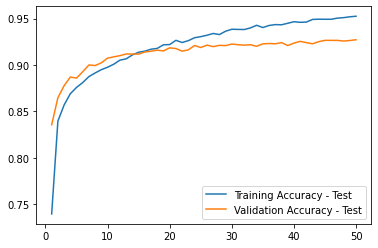

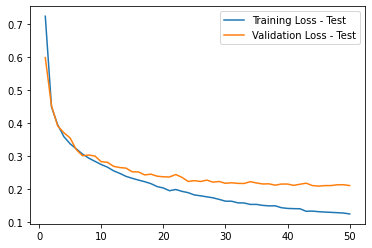

In [194]:
epoch_list_1 = list(range(1, len(hist1.history['accuracy']) + 1))
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
plt.legend(("Training Loss - Test", "Validation Loss - Test"))
plt.show()

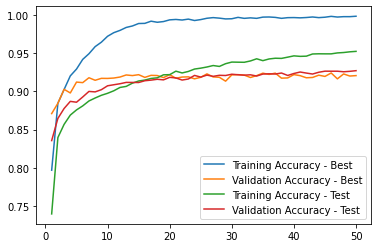

Testing Accuracy - Best: 0.9207070469856262
Testing Accuracy - Test: 0.9271717071533203


In [195]:
#Compare

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.plot(epoch_list_1, hist1.history['accuracy'], epoch_list_1, hist1.history['val_accuracy'])
plt.legend(("Training Accuracy - Best", "Validation Accuracy - Best", "Training Accuracy - Test", "Validation Accuracy - Test"))
plt.show()

#plt.plot(epoch_list_1, hist1.history['loss'], epoch_list_1, hist1.history['val_loss'])
#plt.legend(("Training Loss - Test", "Validation Loss - Test"))
#plt.show()


print("Testing Accuracy - Best:", score[1])
print("Testing Accuracy - Test:", score_1[1])

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

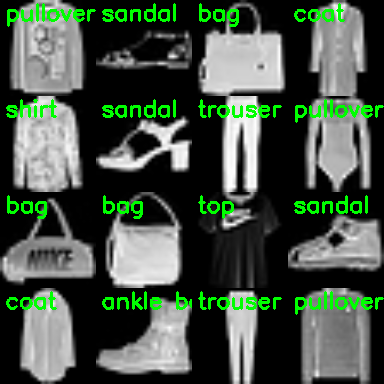

-1

In [196]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

In [197]:
# BEST SO FAR

epochs = 50                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 200          # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#

###Test####

model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 #kernel_initializer='he_normal',
                 input_shape=input_shape))
model_1.add(Dropout(0.7))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3,3)))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.6))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dense(400))  
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


#Testing Accuracy - Test: 0.9271717071533203